# Setup

**Imports**

In [127]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

import scipy
import ruptures as rptplus

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [128]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [129]:
signal, symbols = X_train[51], y_train[50]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

A 6 3


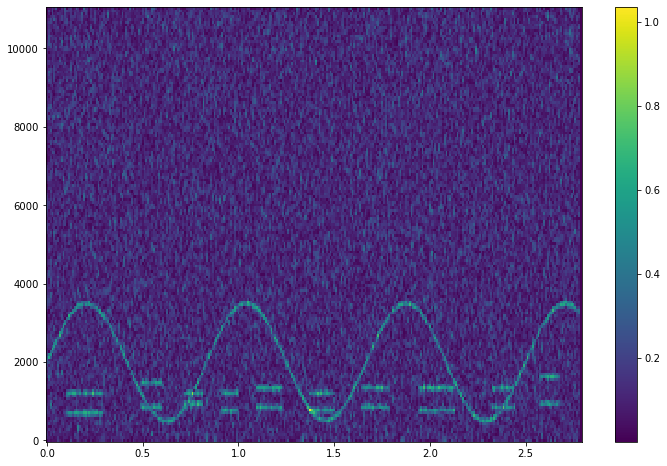

In [130]:
Idx = 66
f, t, Zxx = scipy.signal.stft(X_train[Idx], fs = FS, noverlap=100, nperseg=312,padded=True)
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, np.abs(Zxx))
plt.colorbar()
plt.show()

1060.0961538461538


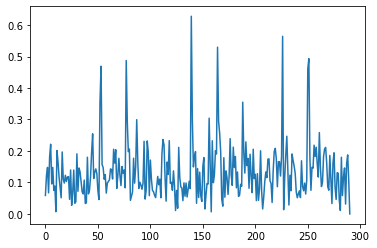

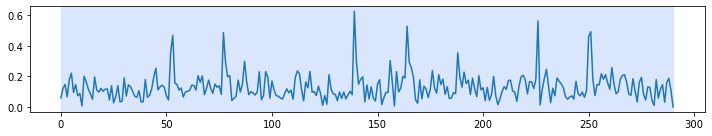

In [131]:
magnitude = np.abs(Zxx)
idx = 15
test_sig = magnitude[idx, :]
print(f[idx])

predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(test_sig, pen=0.2)

plt.plot(test_sig)

fig, ax = rpt.display(test_sig, predicted_bkps,predicted_bkps)

In [132]:
def load_dict_from_txt(file_path):
    result_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            result_dict[key] = value
    return result_dict

In [133]:
match = []
list_symbols = [str(i) for i in range(10)] + ["*", "#", "A", "B", "C", "D"]
sym2freq = dict()
for s in list_symbols :
    sym2freq[s] = []

Looking at the signals we can consider that the frequencies of interest lie in [500, 2000]Hz above that we can neglect, we can also neglect intervals that are shorter than a given threshold. This preprocessing will be done in a clean() function.

In [134]:
def size(interval) :
    return interval[1]-interval[0]

def check_interval_alignment(dictionary, min_size=0.02, max_size=1, eps=0.05):
    aligned = True
    symbols = {}
    intervals = []

    keys = list(dictionary.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            intervals_a = dictionary[keys[i]]
            intervals_b = dictionary[keys[j]]

            for interval_a in intervals_a:
                for interval_b in intervals_b:
                    delta_a = size(interval_a)
                    delta_b = size(interval_b)
                    # Check for overlap between intervals
                    if interval_a[0] <= interval_b[1] and interval_a[1] >= interval_b[0]:
                        if delta_a>min_size and delta_b < max_size and delta_b>min_size and delta_b<max_size and abs(interval_a[0]-interval_b[0])<eps and abs(interval_a[1]- interval_b[1])<eps :
                            if abs(keys[i]-keys[j])>1 :
                                intervals.append((interval_a))
                                symbols[interval_a] = (keys[i], keys[j])
                        aligned = False
    return intervals, symbols
        
def clean(intervals, symbols, eps=0.1): #clean the detected intervals
    clean_intervals = []
    clean_symbols = dict()
    n = len(intervals)
    visited = [False for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if abs(intervals[i][0]-intervals[j][0])<eps or abs(intervals[i][1]-intervals[j][1])<eps : #consider intervals that are close in length and overlap to be the same
                if visited[i] :
                    visited[j] = True
                else :
                    clean_intervals.append(intervals[i])
                    clean_symbols[intervals[i]] = symbols[intervals[i]]
                    visited[i] = True
                    visited[j] = True
            
        if not visited[i] :
            clean_intervals.append(intervals[i])
            clean_symbols[intervals[i]] = symbols[intervals[i]]
            visited[i] = True
            
    return clean_intervals, clean_symbols

def get_frequencies(IDX) : #build the symbol dictionnary
    f, t, Zxx = scipy.signal.stft(X_train[IDX], fs = FS, noverlap=100, nperseg=312,padded=True)

    magnitude = np.abs(Zxx)
    predicted_bkps = []

    for idx in range(len(f)//4):
        n = len(magnitude[idx, :])
        predicted_bkps.append(rpt.Pelt(model="l2", jump=1).fit_predict(magnitude[idx, :], pen=0.25)[:-1])
    img = np.copy(magnitude)
    activations = {}
    for i, el in enumerate(predicted_bkps):
        n_seg = len(el) // 2
        if n_seg > 0:
            if i >= 10 :
                activations[i] = []
            for j in range(len(el) //2):
                interval = (t[el[2*j]], t[el[2*j+1]])
                if i >= 10 : #outline the detected activations
                    img[i, el[2*j]:el[2*j+1]] = 2 #magnitude for the image to show
                    activations[i].append(interval)                

    intervals, symbols = check_interval_alignment(activations)
    intervals = list(set(intervals))
    intervals.sort()
    intervals, symbols = clean(intervals, symbols) #clean the intervals and detected symbols
    print(len(symbols))
    print(symbols)
    print(y_train[IDX])
    print("Found all the symbols :", len(intervals)==len(y_train[IDX]))
    match.append(len(intervals)==len(y_train[IDX]))
    if len(intervals)==len(y_train[IDX]) :
        for i, s in enumerate(y_train[IDX]) : 
            if i < len(intervals) :
                pair = symbols[intervals[i]]  
                if abs(pair[0]-pair[1])>1:
                    sym2freq[s].append(pair) #add frequency pair to the dictionnary
    return intervals, symbols

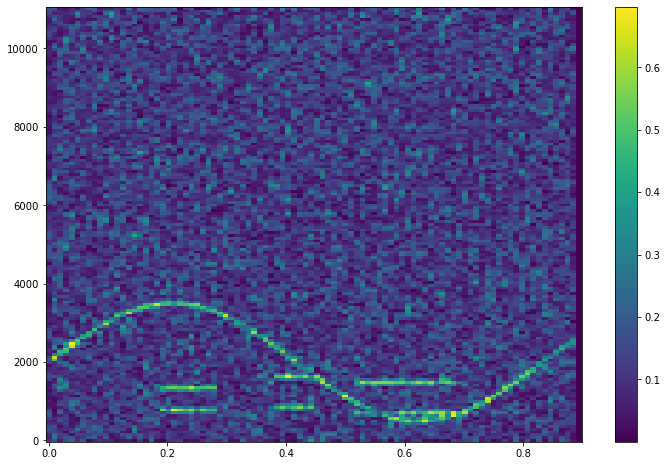

In [135]:
f, t, Zxx = scipy.signal.stft(X_train[0], fs = FS, noverlap=100, nperseg=312,padded=True)
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, np.abs(Zxx))
plt.colorbar()
plt.show()

In [136]:
match = []
list_symbols = [str(i) for i in range(10)] + ["*", "#", "A", "B", "C", "D"]
sym2freq = dict()
for s in list_symbols :
    sym2freq[s] = []


## Running last 10 minutes
#idx = np.random.randint(0, 100, 20)
idx = np.arange(100)
for IDX in idx :
    intervals, symbols = get_frequencies(IDX)

KeyboardInterrupt: 

In [ ]:
sym2freq

{'0': [(13, 19),
  (13, 19),
  (14, 19),
  (14, 19),
  (14, 19),
  (13, 19),
  (14, 19),
  (14, 19),
  (14, 19),
  (13, 19),
  (14, 19),
  (13, 19),
  (13, 19),
  (14, 19),
  (13, 19)],
 '1': [(10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 18),
  (10, 17),
  (10, 18),
  (10, 17),
  (10, 17),
  (10, 18),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 17),
  (10, 18),
  (10, 17)],
 '2': [(10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19),
  (10, 19)],
 '3': [(10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10, 21),
  (10

We notice some outliers that will cause issues for the decoding, let's remove them :

In [ ]:
thresh = 0.1
for item in sym2freq.items():
    appearence = dict()
    seen = []
    num_pairs = len(item[1])
    for pair in item[1]:
        if pair not in seen:
            seen.append(pair)
            appearence[pair] = 0
        else:
            appearence[pair] += 1 / num_pairs
    for ap in appearence.items():
        if ap[1] < thresh:
            item[1].remove(ap[0])
            print(f"Removing the pair {ap[0]} for the symbol \"{item[0]}\"")

#set the lists of sym to sets to remove redunduncy:

for key in sym2freq.keys():
    sym2freq[key] = set(sym2freq[key])

Removing the pair (11, 18) for the symbol "4"
Removing the pair (10, 17) for the symbol "4"
Removing the pair (10, 19) for the symbol "5"
Removing the pair (12, 18) for the symbol "7"
Removing the pair (13, 21) for the symbol "9"
Removing the pair (16, 18) for the symbol "*"
Removing the pair (14, 18) for the symbol "*"
Removing the pair (10, 23) for the symbol "B"
Removing the pair (13, 24) for the symbol "C"
Removing the pair (13, 23) for the symbol "C"
Removing the pair (12, 24) for the symbol "C"
Removing the pair (14, 24) for the symbol "D"


In [ ]:
sym2freq

{'0': {(13, 19), (14, 19)},
 '1': {(10, 17), (10, 18)},
 '2': {(10, 19)},
 '3': {(10, 21)},
 '4': {(10, 17), (11, 17), (11, 18)},
 '5': {(10, 19), (11, 19)},
 '6': {(10, 21), (11, 21)},
 '7': {(12, 17), (12, 18)},
 '8': {(12, 19), (13, 19)},
 '9': {(12, 21)},
 '*': {(13, 17), (14, 17)},
 '#': {(13, 21), (14, 21)},
 'A': {(10, 23), (10, 24)},
 'B': {(11, 23), (11, 24)},
 'C': {(12, 23), (12, 24), (13, 24)},
 'D': {(13, 23), (13, 24), (14, 23), (14, 24)}}

We have successfully built our dictionnary for the decoding task.

# Question 2

In [ ]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

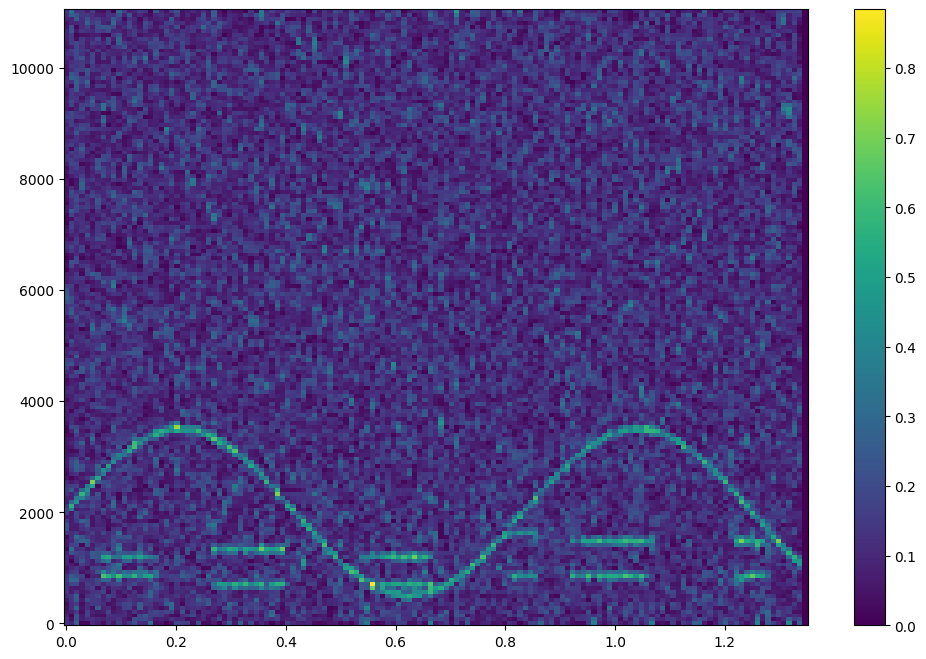

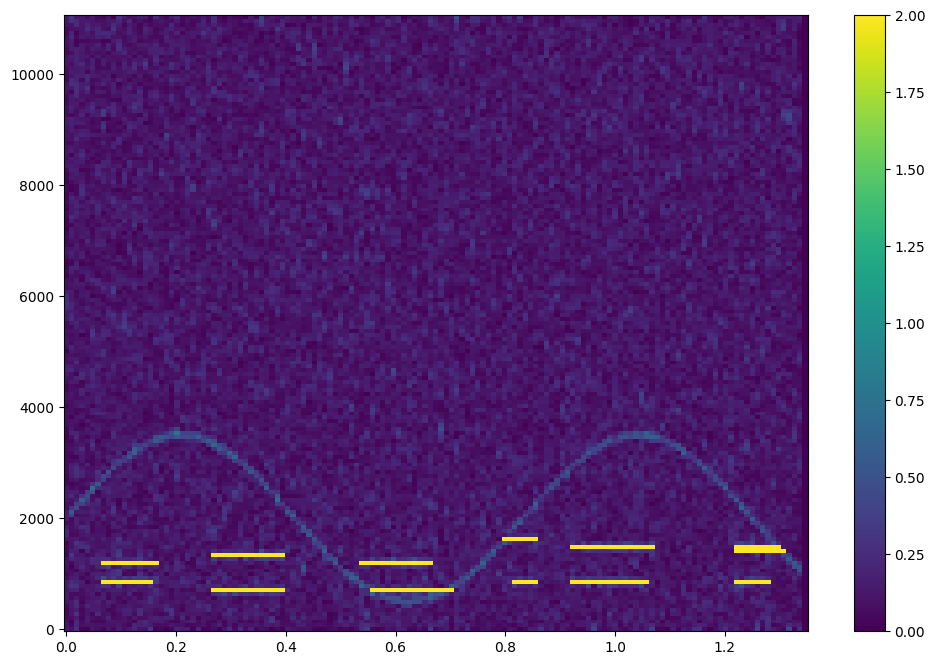

6
[(0.06730158730158729, 0.1634467120181406), (0.2692063492063492, 0.40380952380952384), (0.557641723356009, 0.7114739229024943), (0.8172335600907029, 0.8653061224489795), (0.9229931972789115, 1.0672108843537416), (1.2210430839002269, 1.288344671201814)]


In [ ]:
f, t, Zxx = scipy.signal.stft(X_test[0], fs = FS, noverlap=100, nperseg=312,padded=True)

magnitude = np.abs(Zxx)
predicted_bkps = []

for idx in range(len(f)//4):
    n = len(magnitude[idx, :])
    predicted_bkps.append(rpt.Pelt(model="l2", jump=1).fit_predict(magnitude[idx, :], pen=0.18)[:-1])
img = np.copy(magnitude)
activations = {}
for i, el in enumerate(predicted_bkps):
    n_seg = len(el) // 2
    if n_seg > 0:
        if i >= 10 :
            activations[i] = []
        for j in range(len(el) //2):
            interval = (t[el[2*j]], t[el[2*j+1]])
            if i >= 10 :
                img[i, el[2*j]:el[2*j+1]] = 2
                activations[i].append(interval)
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, np.abs(Zxx))
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, img)
plt.colorbar()
plt.show()                

intervals, symbols = check_interval_alignment(activations)
intervals = list(set(intervals))
intervals.sort()
intervals, symbols = clean(intervals, symbols)
print(len(intervals))
print(intervals)

In [ ]:
def check_item(sym, sequence):
    for item in sym2freq.items():
        for couple in item[1]:
            if couple == sym:
                sequence.append(item[0])
                return

def decode(symbols):
    sequence = []
    for sym in symbols.values():
        check_item(sym, sequence)
    return sequence

sequence = decode(symbols)
print(f"The detected frequency couples are : {list(symbols.values())}")
print(f"The decoded sequence is : {sequence}")

The detected frequency couples are : [(12, 17), (10, 19), (10, 17), (12, 23), (12, 21), (12, 21)]
The decoded sequence is : ['7', '2', '1', 'C', '9', '9']


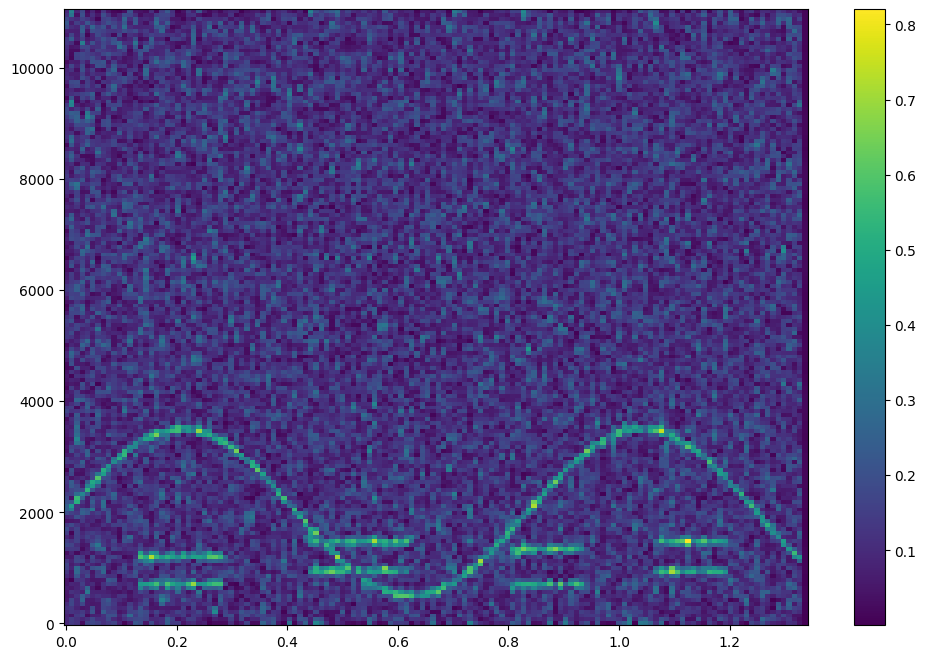

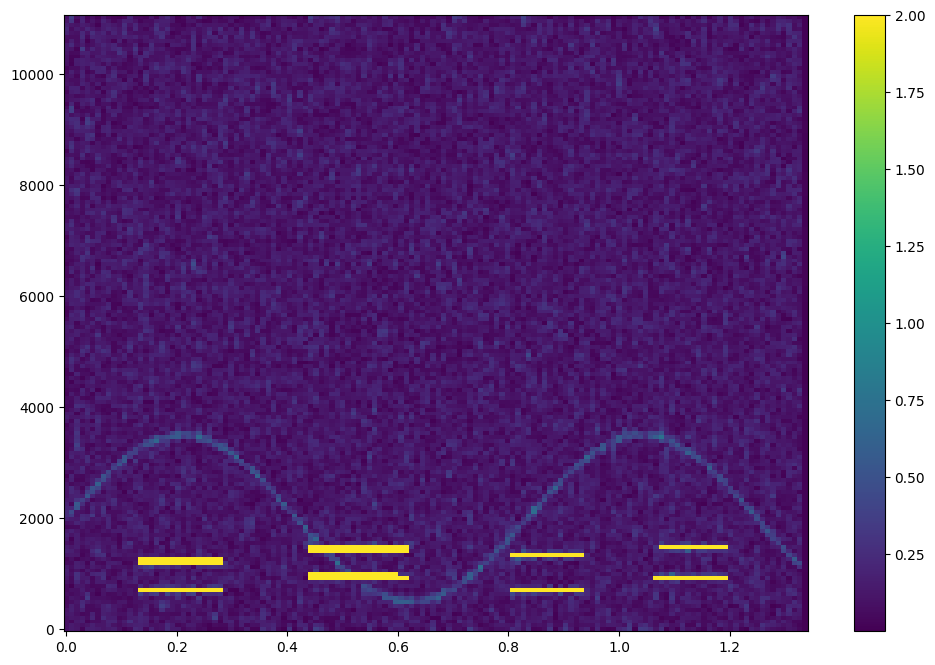

4
[(0.1346031746031746, 0.28843537414965986), (0.4422675736961451, 0.6057142857142856), (0.8076190476190476, 0.9422222222222222), (1.0672108843537416, 1.2018140589569162)]


In [ ]:
f, t, Zxx = scipy.signal.stft(X_test[1], fs = FS, noverlap=100, nperseg=312,padded=True)

magnitude = np.abs(Zxx)
predicted_bkps = []

for idx in range(len(f)//4):
    n = len(magnitude[idx, :])
    predicted_bkps.append(rpt.Pelt(model="l2", jump=1).fit_predict(magnitude[idx, :], pen=0.25)[:-1])
img = np.copy(magnitude)
activations = {}
for i, el in enumerate(predicted_bkps):
    n_seg = len(el) // 2
    if n_seg > 0:
        if i >= 10 :
            activations[i] = []
        for j in range(len(el) //2):
            interval = (t[el[2*j]], t[el[2*j+1]])
            if i >= 10 :
                img[i, el[2*j]:el[2*j+1]] = 2
                activations[i].append(interval)
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, np.abs(Zxx))
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(12, 8))
plt.pcolormesh(t,f, img)
plt.colorbar()
plt.show()                

intervals, symbols = check_interval_alignment(activations)
intervals = list(set(intervals))
intervals.sort()
intervals, symbols = clean(intervals, symbols)
print(len(intervals))
print(intervals)

In [ ]:
signal = X_test[1]
IPython.display.Audio(signal, rate=FS)

In [ ]:
#symbols = dict(sorted(symbols.items())) 
sequence = decode(symbols)
print(f"The detected frequency couples are : {list(symbols.values())}")
print(f"The decoded sequence is : {sequence}")

The detected frequency couples are : [(10, 18), (14, 21), (10, 19), (13, 21)]
The decoded sequence is : ['1', '#', '2', '#']


# Question 3

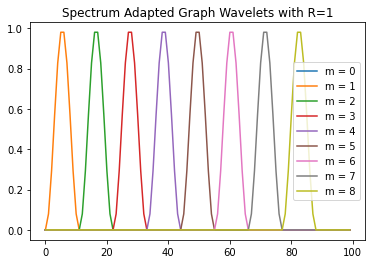

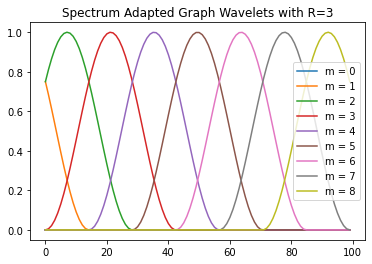

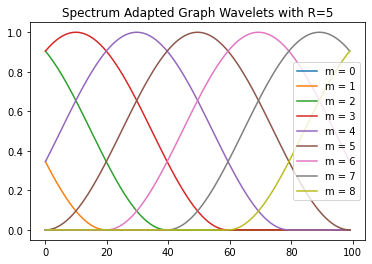

In [ ]:
M = 9
lmda_n = 12

def g_hat(x, a, R):
    if -R*a <= x < 0:
        
        return 0.5*(1 + np.cos(2 * np.pi * (x / (R*a) + 0.5)))
    else:
        return 0

x = np.linspace(0, lmda_n, 100)  

for R in [1, 3, 5]:
    a = lmda_n / (M + 1 - R)
    plt.figure()
    for m in range(M):
        g_m = []
        for xi in x:
            g_m.append(g_hat(xi- a*m, a, R))
        plt.plot(g_m, label=f"m = {m}")
    plt.legend()
    plt.title(f"Spectrum Adapted Graph Wavelets with R={R}")
    plt.savefig(f"R = {R}")

# Question 4

Utilitary functions

In [181]:
from math import asin, cos, radians, sin, sqrt
import re
import contextily as cx
from scipy.spatial.distance import pdist, squareform
from pygsp import graphs
import geopandas
import seaborn as sns
from matplotlib.dates import DateFormatter
from statistics import mode

In [ ]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees lw=2to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g

def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

In [ ]:
CRS = "EPSG:4326"

In [ ]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [ ]:
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df = temperature_df.dropna(axis=1)
STATION_LIST = temperature_df.columns.values.tolist()

In [ ]:
len(STATION_LIST)

37

In [ ]:
# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond].reset_index().drop("index", axis="columns")

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs(CRS)

stations_gdf.head()

Numéro            Nom   Latitude  Longitude  X (Lambert II étendu)  \
0  22016001  ILE-DE-BREHAT  48.855167  -3.004500                 208083   
1  22092001        KERPERT  48.404000  -3.147667                 194096   
3  22135001       LOUARGAT  48.551667  -3.376833                 178359   
4  22147006     MERDRIGNAC  48.182667  -2.410833                 247067   
5  22168001    PLOUMANAC'H  48.825833  -3.473167                 173516   

   Y (Lambert II étendu)  Altitude                   geometry  
0                2441852        25  POINT (-3.00450 48.85517)  
1                2392507       281  POINT (-3.14767 48.40400)  
3                2410097       148  POINT (-3.37683 48.55167)  
4                2364385       131  POINT (-2.41083 48.18267)  
5                2441036        55  POINT (-3.47317 48.82583)

In [ ]:
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name         AURAY  BELLE ILE-LE TALUT  BIGNAN  DINARD  GUERANDE  \
date                                                                       
2014-01-01 00:00:00   10.3                11.3     7.1     6.8      10.4   
2014-01-01 01:00:00   10.4                10.3     7.6     6.5      10.6   
2014-01-01 02:00:00   10.0                11.2     7.7     6.5      10.2   
2014-01-01 03:00:00   10.4                11.4     7.9     7.1      10.6   
2014-01-01 04:00:00   10.8                11.4     8.8     7.6      10.6   

station_name         GUISCRIFF SA  ILE DE GROIX  ILE-DE-BREHAT  KERPERT  \
date                                                                      
2014-01-01 00:00:00           8.3           9.0            7.0      5.9   
2014-01-01 01:00:00           7.8          10.0            7.0      5.9   
2014-01-01 02:00:00           8.4           9.5            7.8      6.4   
2014-01-01 03:00:00           8.4          10.4            8.3      6.7   
2014-01-01 04:00:00           8.9          10.8            8.9      6.9   

station_name         LORIENT-LANN BIHOUE  ...  SAINT-CAST-LE-G  \
date                                      ...                    
2014-01-01 00:00:00                  9.0  ...              6.1   
2014-01-01 01:00:00                 10.0  ...              6.3   
2014-01-01 02:00:00                  8.9  ...              6.4   
2014-01-01 03:00:00                 10.1  ...              7.0   
2014-01-01 04:00:00                 10.4  ...              7.7   

station_name         SAINT-JOACHIM_SAE  SARZEAU SA  SIBIRIL S A  SPEZET  \
date                                                                      
2014-01-01 00:00:00                9.3         9.8          7.4     8.3   
2014-01-01 01:00:00                9.3         9.9          8.2     8.6   
2014-01-01 02:00:00                9.5         9.2          8.5     8.6   
2014-01-01 03:00:00                9.0        10.1          8.5     8.9   
2014-01-01 04:00:00                9.9        10.5          9.1     9.4   

station_name         ST BRIEUC  ST-SEGAL S A  THEIX  TREGUNC  VANNES-SENE  
date                                                                       
2014-01-01 00:00:00        7.5           9.0    9.3     10.8          9.7  
2014-01-01 01:00:00        7.0           9.5    9.1     10.9          9.9  
2014-01-01 02:00:00        7.5           9.4    9.4     10.6          9.6  
2014-01-01 03:00:00        7.2           9.9    8.9     10.8          9.8  
2014-01-01 04:00:00        7.6          10.0    9.6     11.0         10.2  

[5 rows x 37 columns]

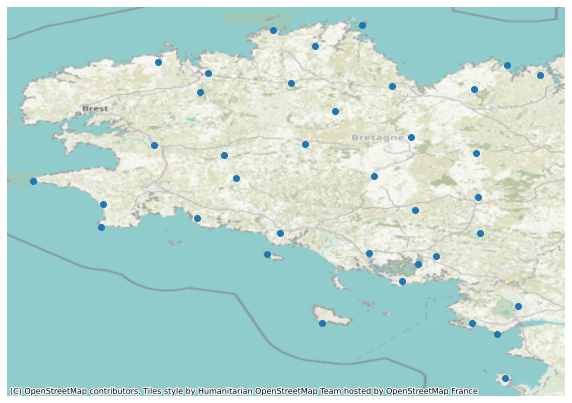

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

In [ ]:
list_of_NAN = temperature_df.isna().sum(axis=0).sort_values(ascending=False)
names_nan = list_of_NAN[list_of_NAN >= 1].index.tolist()

print(names_nan)

[]


91.1968456197339


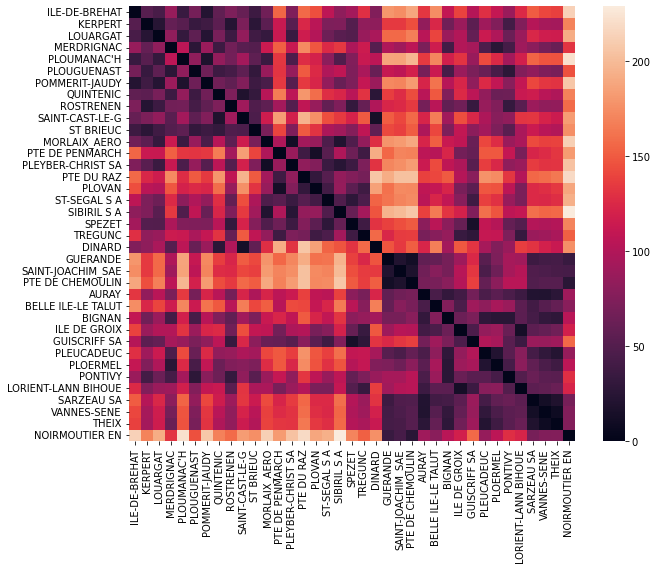

In [ ]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

med = np.median(dist_mat_square.flatten())
print(med)

In [ ]:
def is_connected(graph) -> bool:
    return graph.is_connected()

We have the following definition for the mean degree of a graph : 
$$ \frac{1}{|V|} \sum_{v\in V}{d(v)} = 2\frac{|E|}{|V|}$$

In [ ]:
threshold = 0.83
sigma = np.median(dist_mat_condensed)
adjacency_matrix = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)

G = graphs.Graph(adjacency_matrix)
print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

#average_degrees = 2*G.Ne/G.N
average_degrees = np.sum(adjacency_matrix, axis=1).mean()
print(f"The average degree of the graph is {average_degrees}")

The graph is connected, with 37 nodes, 75 edges
The average degree of the graph is 3.6644587898054466


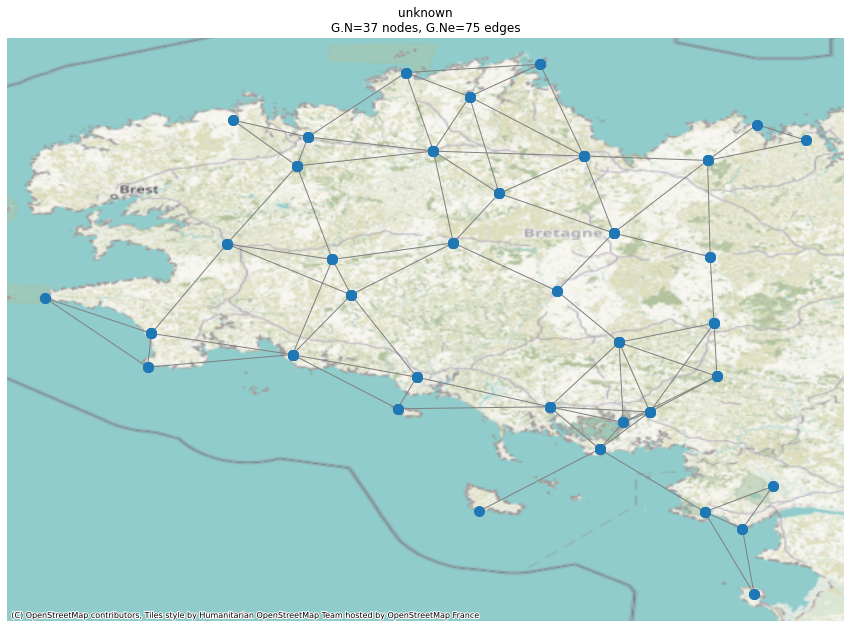

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(15, 15))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)
# plt.title("Graph of meteo stations", fontsize=20)
# plt.show()

In [ ]:
def smoothness(sig, L) : 
    return sig.T@L@sig

In [ ]:
Temp = temperature_df.values
smoothness(sig=Temp[0], L=G.L)

395.46564582150125

In [ ]:
n = len(Temp)
L = G.L
index_min = -1
val_min = np.inf
index_max = -1
val_max = -np.inf
for i in range(n) :
    s = smoothness(Temp[i], L)
    if s < val_min :
        val_min = s
        index_min = i
    if s > val_max :
        val_max = s
        index_max = i

In [ ]:
print("Time where the signal is the least smooth :", index_max, "associated smoothness :", val_max)
print("Time where the signal is the smoothest :", index_min, "associated smoothness :", val_min)

Time where the signal is the least smooth : 225 associated smoothness : 1536.0127016772688
Time where the signal is the smoothest : 571 associated smoothness : 24.394985986074005


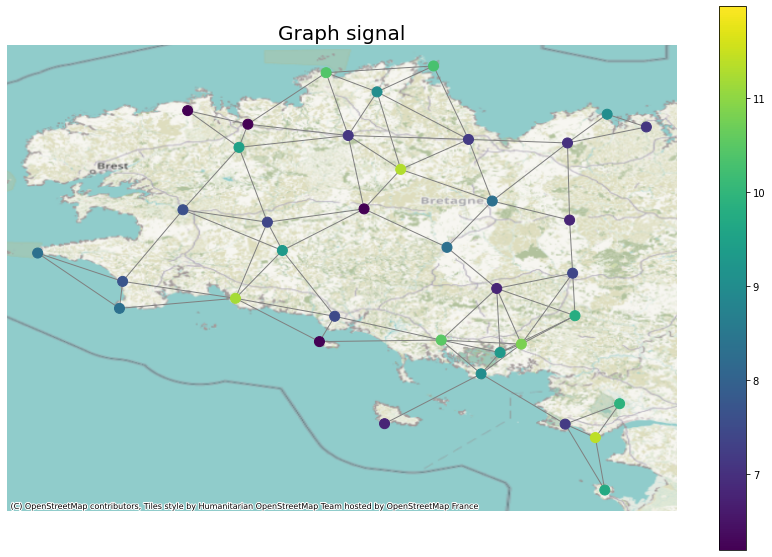

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(np.array(Temp[0]), ax=ax)
plt.title("Graph signal", fontsize=20)
plt.show()

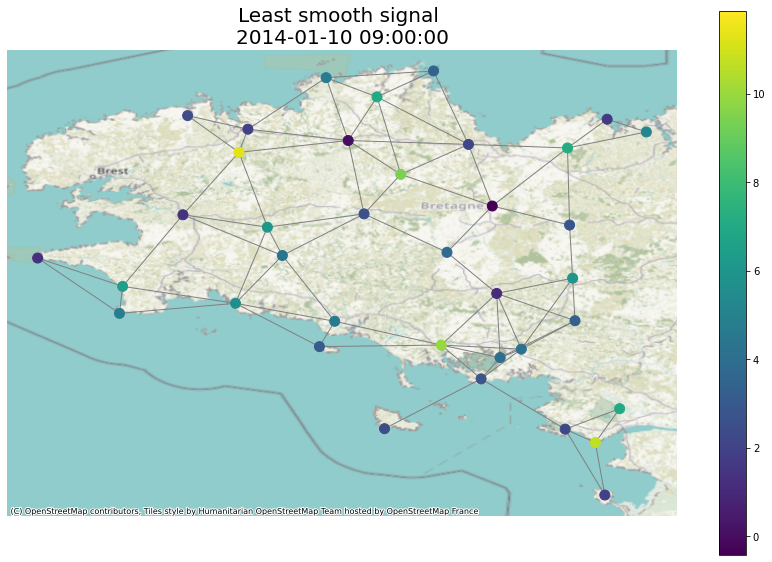

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(np.array(Temp[index_max]), ax=ax)
plt.title("Least smooth signal \n" + str(temperature_df.index[index_max]), fontsize=20)
plt.show()

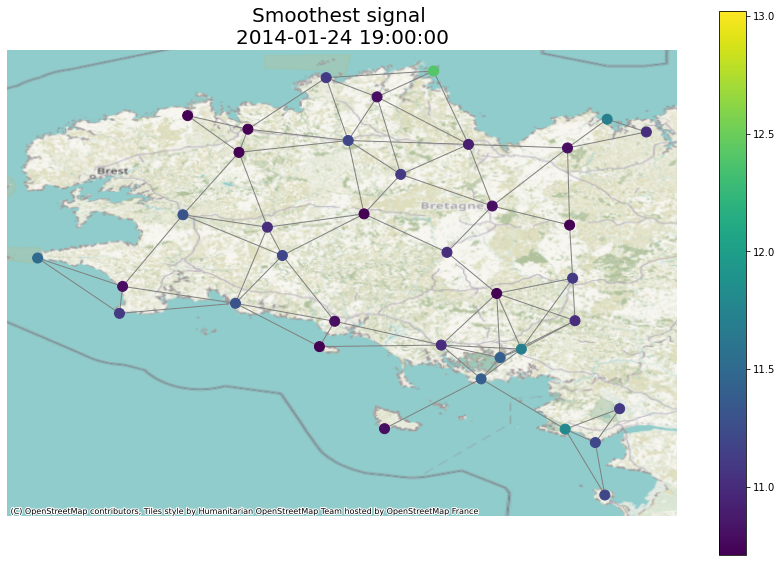

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(np.array(Temp[index_min]), ax=ax)
plt.title("Smoothest signal \n" + str(temperature_df.index[index_min]), fontsize=20)
plt.show()

# Question 5

In [ ]:
L_np = L.toarray()
eigenvalues, eigenvectors = np.linalg.eigh(L_np)
R = 3
M = 9

In [253]:
def GWT(f, m, v) :   
    a = eigenvalues[-1] / (M + 1 - R)
    g_m = []
    for lam_i in eigenvalues:
        g_m.append(g_hat(lam_i - a*m, a, R)) 
    g_m = np.array(g_m)
    f_hat = eigenvectors.T.dot(f) #graph fourier transform
    return np.sum(g_m * f_hat * eigenvectors[v, :])

def energy_class(f):
    V = len(Temp[0])
    Energy = np.empty(V)

    for v in np.arange(V):
        low,med,high = 0, 0, 0
        for m in np.arange(M):
            if m < 3:
                low += GWT(f, m, v)**2
            elif m < 6:
                med += GWT(f, m, v)**2
            else:
                high += GWT(f, m, v)**2
        Energy[v] = np.argmax([low, med, high]) 
        
    return Energy

The list of classes is : [0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


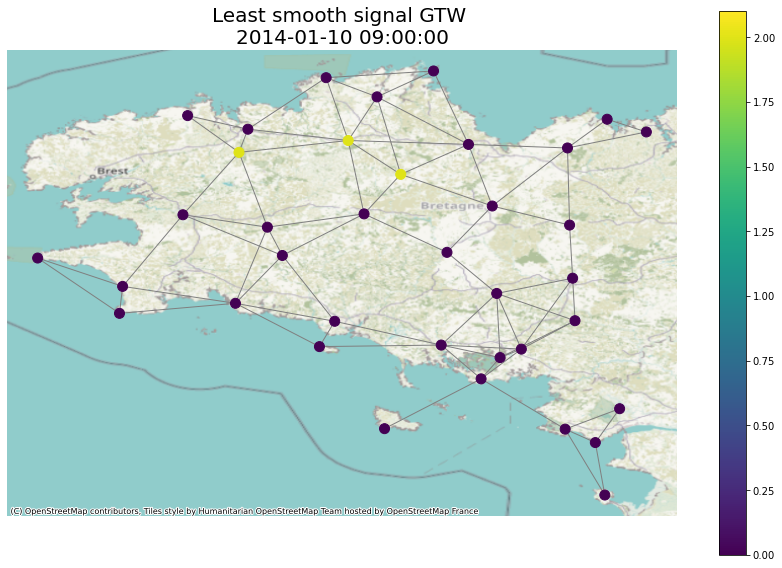

In [196]:
f = Temp[index_max] #Least smooth signal
Energy = energy_class(f)
    
print(f"The list of classes is : {Energy}")

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(Energy, ax=ax)
plt.title("Least smooth signal GTW \n" + str(temperature_df.index[index_max]), fontsize=20)
plt.savefig(f"GTW LS")
plt.show()

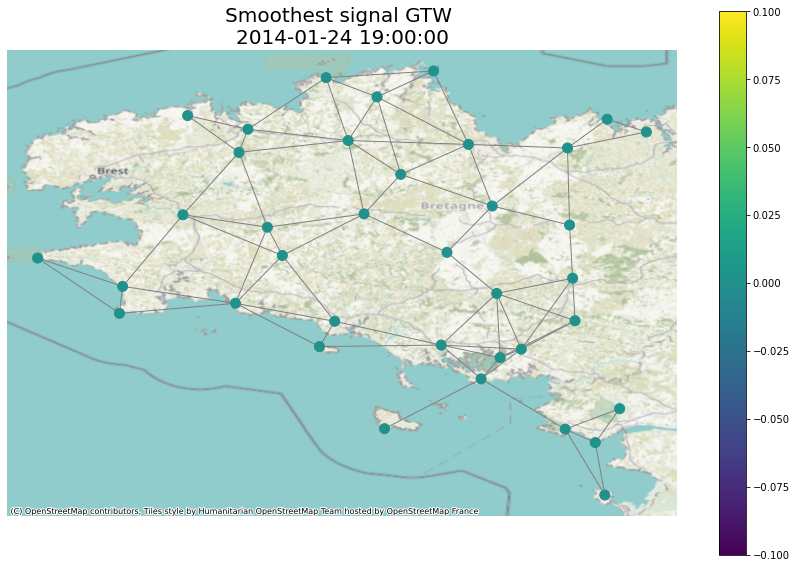

In [197]:
f = Temp[index_min] #Smoothest signal
Energy = energy_class(f)

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(Energy, ax=ax)
plt.title("Smoothest signal GTW \n" + str(temperature_df.index[index_min]), fontsize=20)
plt.savefig(f"GTW S")
plt.show()

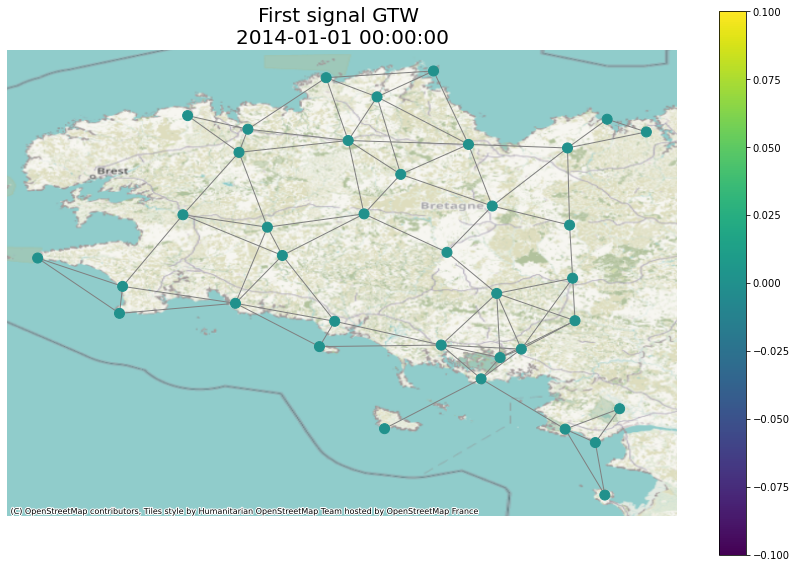

In [198]:
f = Temp[0] #First signal
Energy = energy_class(f)

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(Energy, ax=ax)
plt.title("First signal GTW \n" + str(temperature_df.index[0]), fontsize=20)
plt.savefig(f"GTW F")
plt.show()

# Question 6

In [254]:
markers = []
Mean_temps = np.mean(Temp, axis=1)
for f in Temp:
    Energy = energy_class(f)
    marker = mode(Energy)
    markers.append(marker)

c = []
for m in markers:
    if m == 0:
        c.append("r")
    elif m == 1:
        c.append("g")
    else:
        c.append("b")

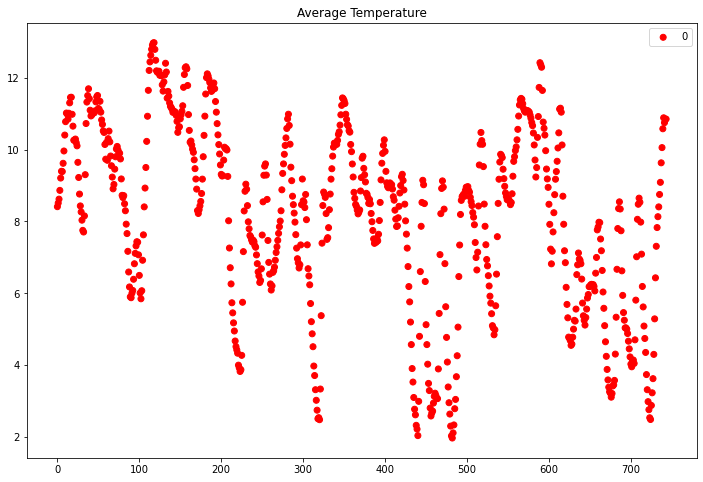

In [257]:
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(Temp)), Mean_temps, c=c)
plt.title("Average Temperature")
plt.legend("0")
plt.savefig("Average_temp1.png")
plt.show()

# Question 7

In [201]:
T = len(Temp[:,0])
print(T)
L_prime = np.eye(T)
L_prime[1:,:-1] -= np.eye(T-1)
L_prime[:-1,1:] -= np.eye(T-1)
L_prime[1:-1,1:-1] += np.eye(T-2)

744


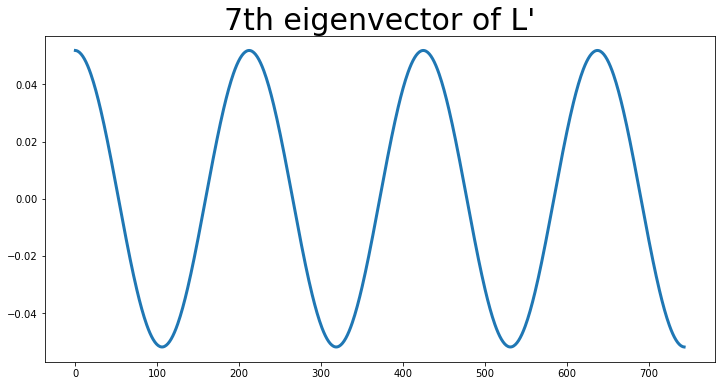

In [202]:
eigenvalues2, eigenvectors2 = np.linalg.eigh(L_prime)
fig = plt.figure(figsize=(12, 6))
plt.plot(eigenvectors2[:,7], lw=3)
i = 7
#plt.plot(L_prime@eigenvectors2[:,i], lw=3)
plt.title(str(i) +"th eigenvector of L'", fontsize=30)
plt.show()

In [225]:
def g_hat(x, a, R):
        return 0.5*(1 + np.cos(2 * np.pi * (x / (R*a) + 0.5)))*(-R*a <= x)*(x < 0)

In [226]:
sig = Temp.flatten()
n = G.N
M = 9
R = 3
nT = np.arange(n*T)
a = (eigenvalues[-1]+eigenvalues2[-1]) / (M + 1 - R)
GWT = np.zeros((M, n*T))
for i in range(n) :
    for j in range(T) :
        eigval = eigenvalues[i] + eigenvalues2[j]
        eigvect1, eigvect2 = eigenvectors[i], eigenvectors2[j]
        eigvect = np.kron(eigvect1, eigvect2)
        f_hat_ij = sig@eigvect
        for m in range(M) :
            GWT[m, :] += g_hat(eigval - a*m, a, R)*f_hat_ij*eigvect

In [205]:
## Classification in low/medium/high frequency
N = len(sig)
Energy = np.empty(N)

for v in np.arange(N):
    low,med,high = 0, 0, 0
    for m in np.arange(M):
        if m < 3:
            low += GWT[m, v]**2
        elif m < 6:
            med += GWT[m, v]**2
        else:
            high += GWT[m, v]**2
    Energy[v] = np.argmax([low, med, high]) 

In [227]:
Energy = Energy.reshape((n, T))

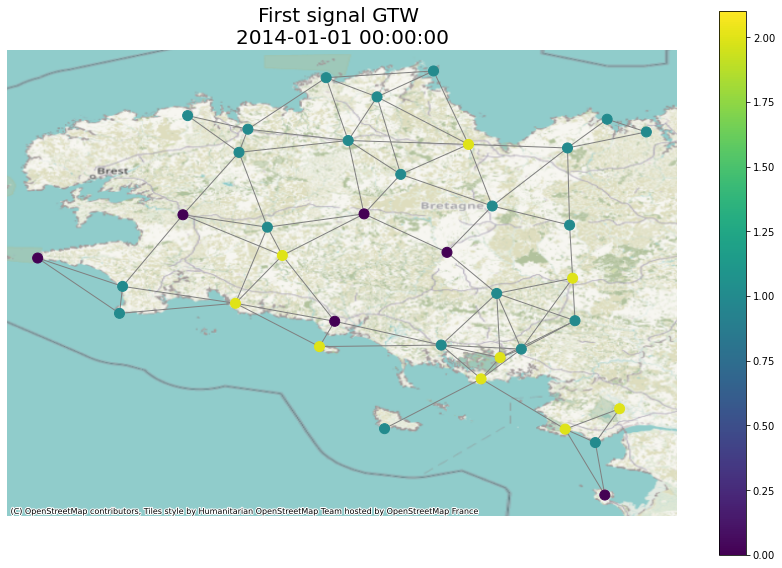

In [228]:
ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(Energy[:,0], ax=ax)
plt.title("First signal GTW \n" + str(temperature_df.index[0]), fontsize=20)
plt.savefig(f"GTW F")
plt.show()

In [229]:
Mean_temps = np.mean(Temp, axis=1)

In [230]:
markers = mode(Energy[:,0])

In [231]:
markers = np.zeros(T)
for t in range(T) :
    markers[t] = mode(Energy[:,t])

In [232]:
markers.shape

(744,)

In [233]:
c=[]
for m in markers:
    if m == 0:
        c.append(0)
    elif m == 1:
        c.append("g")
    else:
        c.append("b")

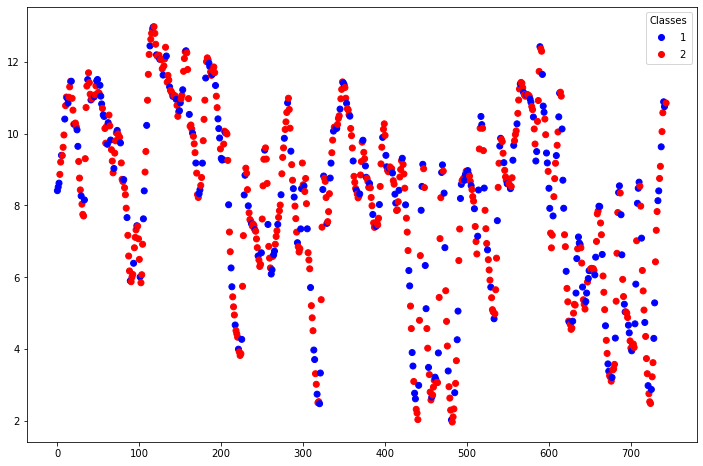

In [252]:
fig = plt.figure(figsize=(12, 8))
scatter = plt.scatter(np.arange(len(Temp)), Mean_temps, c=markers, cmap="bwr")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.savefig("Averag_temp.png")
plt.show()